In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import h5py

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import io


# Load the Data

In [4]:
# Assign the data path.
data_path = "hin.txt"

# Read in the data.
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])
# Split the data into input and target sequences.
lines = [line.split("\t") for line in lines]
print(lines[0])
# We define the starting signal to be "\t" and the
# ending signal to be "\n". These signals tell the
# model that when it sees "\t" it should start
# producing its translation and produce "\n" when
# it wants to end its translation. Let us add
# "\t" to the start and "\n" to the end 
# of all input and output sentences.
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

Jump.	उछलो.
['\ufeffHelp!', 'बचाओ!']


In [5]:
print (lines[0][1])

	बचाओ!



# Figure out the Best Lengths of Sentences

## Compute Sentence Lengths

In [6]:
# Compute the input and output lengths.
input_lengths = np.array([len(line[0]) for line in lines])
output_lengths = np.array([len(line[1]) for line in lines])

In [7]:
print (len(input_lengths))

2870


(75.0, 80.0, 0.0, 120.0)

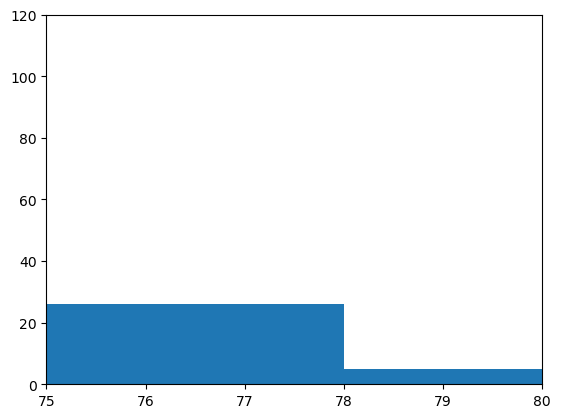

In [8]:
plt.hist(input_lengths)
plt.axis([75,80, 0 , 120])

(85.0, 89.0, 0.0, 20.0)

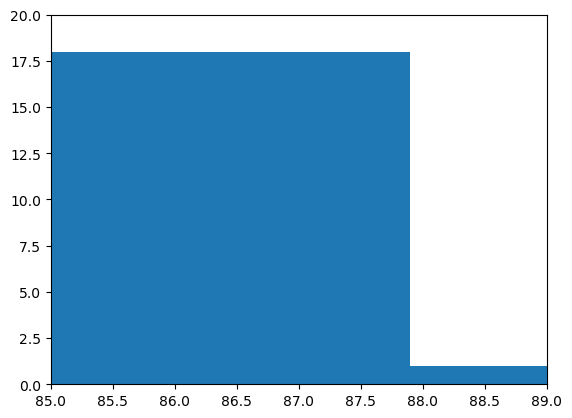

In [9]:
plt.hist(output_lengths)
plt.axis([85,89,0,20])

In [10]:
english = 78
hindi = 87

In [11]:
line1 = []
for i in range(len(input_lengths)):
    if(input_lengths[i]<75 and output_lengths[i]<85):
        line1 = line1 + [lines[i]]
        

In [12]:
print (len(line1))

2857


## Input Length

Plotted the histogram of the length of the input sentences and choose the length that makes the most sense. 

The reason we don't want sentences that are too long is because the computation becomes trickier for longer sentences and the performance also degrades. However we also want as many sentences in our dataset as possible.

Thus it is important to choose the right length and discard sentences longer than this.

## Output Length

Repeat the same for the lengths of the output sentences

In [13]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2869  # Number of samples to train on.

In [14]:
input_texts = [(line[0]) for line in line1]
target_texts = [(line[1]) for line in line1]

In [15]:
input_characters = set()
target_characters = set()

In [16]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [17]:
print (len(input_characters))
print (len(target_characters))

73
92


In [18]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [19]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2857
Number of unique input tokens: 73
Number of unique output tokens: 92
Max sequence length for inputs: 74
Max sequence length for outputs: 82


In [20]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [21]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [22]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [23]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [24]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [25]:
epochs = 100

In [26]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 1.4797 - val_loss: 2.0893
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - loss: 1.2740 - val_loss: 2.0656
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 1.2605 - val_loss: 2.0621
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - loss: 1.2551 - val_loss: 2.0578
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - loss: 1.2490 - val_loss: 2.0663
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 1.2552 - val_loss: 2.0484
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - loss: 1.2515 - val_loss: 2.0269
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - loss: 1.2611 - val_loss: 2.0476
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - loss: 1.2408 - val_loss: 2.0417
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - loss: 1.2319 - val_loss: 2.0411
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - loss: 1.2343 - val_loss: 2.0319
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
model.save('s2s.h5')


In [28]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [37]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


In [38]:
for seq_index in range(100):
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m2155881738256\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=('tf.Tensor(shape=(1, 1, 92), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)')\n  • training=False\n  • mask=('None', 'None', 'None')"

In [39]:
import http.client

conn = http.client.HTTPSConnection("google-translate113.p.rapidapi.com")

payload = "from=auto&to=en&text=xin%20ch%C3%A0o"

headers = {
    'content-type': "application/x-www-form-urlencoded",
    'X-RapidAPI-Key': "SIGN-UP-FOR-KEY",
    'X-RapidAPI-Host': "google-translate113.p.rapidapi.com"
}

conn.request("POST", "/api/v1/translator/text", payload, headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"message":"You are not subscribed to this API."}


In [32]:

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

while True:
    # Get user input
    input_sentence = input("Enter a sentence to translate (type 'quit' to exit): ")

    # Check if the user wants to quit
    if input_sentence.lower() == 'quit':
        print("Exiting...")
        break

    # Encode the input sentence
    input_sequence = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence):
        if char in input_token_index:
            input_sequence[0, t, input_token_index[char]] = 1.

    # Decode the input sequence and print the translated sentence
    translated_sentence = decode_sequence(input_sequence)
    print("Translated Sentence:", translated_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m2155881738256\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=('tf.Tensor(shape=(1, 1, 92), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)')\n  • training=False\n  • mask=('None', 'None', 'None')"

In [34]:
# Function to translate English sentences to Hindi
def translate_to_hindi(input_sentence):
    # Encode the input sentence
    input_sequence = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence):
        if char in input_token_index:
            input_sequence[0, t, input_token_index[char]] = 1.
    
    # Decode the input sequence and get the translated sentence
    translated_sentence = decode_sequence(input_sequence)
    
    return translated_sentence

# Get user input and translate to Hindi
while True:
    # Get user input
    input_sentence = input("Enter an English sentence to translate (type 'quit' to exit): ")
    
    # Check if the user wants to quit
    if input_sentence.lower() == 'quit':
        print("Exiting...")
        break
    
    # Translate the input sentence to Hindi
    translated_sentence = translate_to_hindi(input_sentence)
    
    # Print the translated sentence
    print("Translated Sentence (Hindi):", translated_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m2155881738256\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=('tf.Tensor(shape=(1, 1, 92), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)')\n  • training=False\n  • mask=('None', 'None', 'None')"

In [1]:

from google.cloud import translate_v2 as translate

def translate_text(text, target_language='en'):
    """
    Translates the given text to the specified target language.
    
    Args:
        text (str): The text to be translated.
        target_language (str): The target language code (e.g., 'en' for English, 'hi' for Hindi).
    
    Returns:
        str: Translated text.
    """
    # Initialize the translation client
    client = translate.Client()

    # Translate the text
    translation = client.translate(text, target_language=target_language)

    return translation['translatedText']

# Prompt the user to input text
input_text = input("Enter the text to be translated: ")

# Ask the user for the target language
target_language = input("Enter the target language ('en' for English, 'hi' for Hindi): ")

# Translate the input text
translated_text = translate_text(input_text, target_language=target_language)

# Display the translated text
print("Translated text:", translated_text)


DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [7]:
import requests

def translate_text(text, target_language='en'):
    """
    Translates the given text to the specified target language using the Google Translate API via RapidAPI.

    Args:
        text (str): The text to be translated.
        target_language (str): The target language code (e.g., 'en' for English, 'hi' for Hindi).

    Returns:
        str: Translated text.
    """
    url = "https://google-translate113.p.rapidapi.com/api/v1/translator/text"
    headers = {
        "content-type": "application/x-www-form-urlencoded",
        "X-RapidAPI-Key": "88cbbe7183mshd74b505065ae9bbp116d8ejsn6f397dab0add",
        "X-RapidAPI-Host": "google-translate113.p.rapidapi.com"
    }
    payload = {
        "from": "auto",
        "to": target_language,
        "text": text
    }

    response = requests.post(url, data=payload, headers=headers)
    translated_text = response.json().get('data', {}).get('translation')

    return translated_text

# Example usage
input_text = "Bonjour"
target_language = "en"
translated_text = translate_text(input_text, target_language)
print("Translated text:", translated_text)


Translated text: None
